In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
from pyspark.mllib.recommendation import ALS
from pyspark.sql.functions import col
import math
import random
import itertools
import copy
from joblib import Parallel, delayed
import multiprocessing
import pickle
import scipy.optimize as sco

from cross_validation import KFoldIndexes,CrossValidation
from cross_validation_blending import CrossValidationBlending
from models.als import predictions_ALS
from models.means import *
from models.medians import *
from models.helpers import *
from models.collaborative_filtering import *
from models.MF_SGD import *
from models.pyfm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 100
sc.setCheckpointDir('./checkpoint/')

/home/gael/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train = load_csv()
train.head()

,User,Movie,Rating
0,44,1,4
1,61,1,3
2,67,1,4
3,72,1,3
4,86,1,5


In [4]:
models = {
    'global_mean': {
        'compute_predictions': False,
        'function': global_mean,
        'params': {}    
    },
    'user_mean': {
        'compute_predictions': False,
        'function': user_mean,
        'params': {}
    },
    'movie_mean': {
        'compute_predictions': False,
        'function': movie_mean,
        'params': {}
    },
    'global_median': {
        'compute_predictions': False,
        'function': global_median,
        'params': {}    
    },  
    'user_median': {
        'compute_predictions': False,
        'function': user_median,
        'params': {}
    },
    'movie_median': {
        'compute_predictions': False,
        'function': movie_median,
        'params': {}
    }
}

models2 = {
    'movie_mean_deviation_user': {
        'compute_predictions': False,
        'function': movie_mean_deviation_user,
        'params': {}
    },
    'movie_median_deviation_user': {
        'compute_predictions': False,
        'function': movie_median_deviation_user,
        'params': {}
    }
}

models3 = {
    'als': {
        'compute_predictions': False,
        'function': predictions_ALS,
        'params': {
            'spark_context': sc,
            'rank': 8,
            'lambda_': 0.081, 
            'iterations': 24, 
            'nonnegative': True
        }
    },
    'collab_filt': {
        'compute_predictions': False,
        'function': collaborative_filtering,
        'params': {
            'movie_features':20, 
            'alpha':19
        }  
    },
    'mf_sgd': {
        'compute_predictions': False,
        'function': matrix_factorization_SGD_rescaling,
        'params': {
            'gamma': 0.004,
            'n_features': 20,
            'n_iter': 20,
            'init_method': 'global_mean'
        }
    },
    'pyfm': {
        'compute_predictions': False,
        'function': pyfm,
        'params': {
            'num_factors': 20,
            'num_iter': 100,
            'task': 'regression',
            'initial_learning_rate': 0.001,
            'learning_rate_schedule': 'optimal'
        }
    }
}

models = dict(models, **models2)

models = dict(models, **models3)

In [5]:
def prepare_blending(data, k_folds, models):
    blending = CrossValidationBlending(data, k_folds)
    for key in models.keys():
        blending.add_model(models[key]['function'], key)
    return blending

def add_param_blending(blending, models):
    for key in models.keys():
        blending.add_params_for_model(key, models[key]['params'], compute_predictions=models[key]['compute_predictions'])
        
    return blending

def test_blending(blending, best_dict, models):
    dict_try = {}
    for key in models.keys():
        dict_try[key] = 0
        
    for key in models.keys():
        dict_test = dict_try.copy()
        dict_test[key] = 1
        rmse = blending.evaluate_blending(dict_test)
        print("RMSE for model %s: %.5f"%(key, rmse))
        
    print()
    rmse = blending.evaluate_blending(best_dict)
    print("Best blending: %s"%best_dict)
    print("RMSE best blending: %.5f"%rmse)
    
def prediction(train, blending, best_dict, output):
    test = pd.read_csv('../data/sampleSubmission.csv')
    test_prep = test
    test_prep['User'] = test_prep['Id'].apply(lambda x: int(x.split('_')[0][1:]))
    test_prep['Movie'] = test_prep['Id'].apply(lambda x: int(x.split('_')[1][1:]))
    test_prep['Rating'] = test_prep['Prediction']
    test_prep = test_prep.drop(['Prediction', 'Id'], axis=1)
    
    pred = blending.evaluate_blending_for_validation(best_dict, train, test_prep)
    for i in range(len(pred)):
        if pred[i] > 5:
            pred[i] = 5
        elif pred[i] < 1:
            pred[i] = 1
    
    test.Rating=pred
    test['Prediction']=test.Rating
    test = test.drop(['User', 'Movie', 'Rating'], axis=1)
    test.to_csv(output, index=False)
    
def eval_(x, blending, models):
    dict_try = {}
    for idx, key in enumerate(models.keys()):
        dict_try[key] = x[idx] 
        
    return blending.evaluate_blending(dict_try)

In [6]:
blending = prepare_blending(train, 5, models)

In [7]:
blending = add_param_blending(blending, models)

In [13]:
x0 = [ -3.81181349e+00,  -1.68573031e-01,   7.52569233e-01,
         1.65276869e+00,   3.00501141e-01,  -2.27553228e+00,
        -1.57271265e+00,   2.27933689e+00,   3.62748552e-03,
         4.35628858e-02,   8.82566122e-01,   2.87634963e+00]
#res = sco.minimize(eval_, x0, method='Nelder-Mead', args=(blending, models), options={'maxiter':1000, 'disp':True})

In [31]:
res

array([ -3.81181349e+00,  -1.68573031e-01,   7.52569233e-01,
         1.65276869e+00,   3.00501141e-01,  -2.27553228e+00,
        -1.57271265e+00,   2.27933689e+00,   3.62748552e-03,
         4.35628858e-02,   8.82566122e-01,   2.87634963e+00])

In [14]:
dict_opt = {}
for idx, key in enumerate(models.keys()):
    dict_opt[key] = x0[idx]
dict_opt

{'als': 0.752569233,
 'collab_filt': 0.0435628858,
 'global_mean': 2.87634963,
 'global_median': 0.882566122,
 'mf_sgd': -0.168573031,
 'movie_mean': -1.57271265,
 'movie_mean_deviation_user': 1.65276869,
 'movie_median': -2.27553228,
 'movie_median_deviation_user': 2.27933689,
 'pyfm': 0.300501141,
 'user_mean': -3.81181349,
 'user_median': 0.00362748552}

In [11]:
test_blending(blending, dict_opt, models)

Predictions not available for model user_mean


TypeError: exceptions must derive from BaseException

In [15]:
prediction(train, blending, dict_opt, 'pred_blending.csv')

[USER_MEAN] applying
[USER_MEAN] done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9895411617478957
[MF-SGD] Done
[ALS] applying
[ALS] done
[MOVIE_MEAN_DEVIATION_USER] applying
[MOVIE_MEAN_DEVIATION_USER] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done
[MOVIE_MEDIAN] applying
[MOVIE_MEDIAN] done
[MOVIE_MEAN] applying
[MOVIE_MEAN] done
[MOVIE_MEDIAN_DEVIATION_USER] applying
[MOVIE_MEDIAN_DEVIATION_USER] done
[USER_MEDIAN] applying
[USER_MEDIAN] done
[COLLABORATIVE FILTERING] applying


/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:61: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  model = Ridge(fit_intercept=False, alpha=alpha)
/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  model = Ridge(fit_intercept=False, alpha=alpha)


[COLLABORATIVE FILTERING] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[PYFM] applying
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.54254
-- Epoch 2
Training MSE: 0.51051
-- Epoch 3
Training MSE: 0.50214
-- Epoch 4
Training MSE: 0.49755
-- Epoch 5
Training MSE: 0.49464
-- Epoch 6
Training MSE: 0.49254
-- Epoch 7
Training MSE: 0.49091
-- Epoch 8
Training MSE: 0.48960
-- Epoch 9
Training MSE: 0.48840
-- Epoch 10
Training MSE: 0.48728
-- Epoch 11
Training MSE: 0.48617
-- Epoch 12
Training MSE: 0.48516
-- Epoch 13
Training MSE: 0.48409
-- Epoch 14
Training MSE: 0.48293
-- Epoch 15
Training MSE: 0.48181
-- Epoch 16
Training MSE: 0.48062
-- Epoch 17
Training MSE: 0.47932
-- Epoch 18
Training MSE: 0.47799
-- Epoch 19
Training MSE: 0.47656
-- Epoch 20
Training MSE: 0.47510
-- Epoch 21
Training MSE: 0.47357
-- Epoch 22
Training MSE: 0.47203
-- Epoch 23
Training MSE: 0.47041
-- Epoch 24
Training MSE: 0.46880
-- Epoch 25
Training MSE

In [16]:
df = pd.read_csv('pred_blending.csv')
df.head()

,Id,Prediction
0,r37_c1,3.228966
1,r73_c1,3.104469
2,r156_c1,3.810373
3,r160_c1,3.367049
4,r248_c1,3.670515


In [17]:
pred = list(df.Prediction)

(array([  6.10000000e+01,   8.30000000e+01,   2.65000000e+02,
          5.73000000e+02,   1.32000000e+03,   2.83400000e+03,
          5.67800000e+03,   1.10790000e+04,   2.03590000e+04,
          3.59390000e+04,   5.98270000e+04,   9.10850000e+04,
          1.25902000e+05,   1.55632000e+05,   1.72759000e+05,
          1.68259000e+05,   1.40718000e+05,   9.87270000e+04,
          5.50160000e+04,   3.08360000e+04]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,
         3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 <a list of 20 Patch objects>)

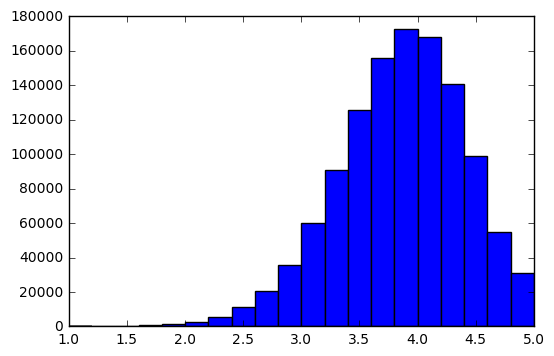

In [18]:
plt.hist(pred, bins=20)

(array([  5.00000000e+01,   9.20000000e+01,   1.94000000e+02,
          5.07000000e+02,   1.26600000e+03,   2.75100000e+03,
          5.68900000e+03,   1.06040000e+04,   1.98780000e+04,
          3.41270000e+04,   5.71770000e+04,   8.86940000e+04,
          1.23696000e+05,   1.54814000e+05,   1.74385000e+05,
          1.73022000e+05,   1.47484000e+05,   1.02678000e+05,
          5.39810000e+04,   2.58630000e+04]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,
         3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 <a list of 20 Patch objects>)

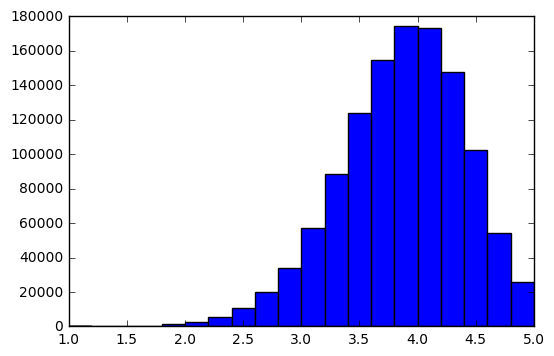

In [37]:
plt.hist(pred, bins=20)